## Check the pages with AlexNet

In [1]:
import torch
import numpy as np
import SimpleITK as sitk
import pandas as pd
import torchio as tio
import ast
import copy
import os
import shutil
import matplotlib.pyplot as plt
from model import MRNet
from utils import preprocess_data

/home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
2023-05-30 14:58:36.933267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-30 14:58:36.933315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-30 14:58:36.933319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some Ten

In [39]:
def case_names(disease_num,case_num=60):
    labels_dir = "../../new_data/ACL.csv"
    labels_df = pd.read_csv(labels_dir)
    pathologys = labels_df.columns.tolist()
    pathology = pathologys[disease_num]
    names = labels_df["StudyUID"].tolist()[:case_num]
    return names,labels_df,pathology

In [36]:
def predict(names,disease_num,view,fold_num=0):
    predictions = []
    for name in names:
        # Load the saved model
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = MRNet().to(device)
        checkpoint = torch.load(f'./models/2023-05-30_10-42/Alex_Fold{fold_num}_{view}.pt')
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()

        # Load the test data and apply transforms
        case_path = f'../../previous_dataset/Preprocessed_dataset_2/{name}/{view.upper()}_PROTON.nii'
        case_tensor = preprocess_data(case_path).to(device)
        # print(f"case_shape: {case_tensor.shape}")

        # Make predictions on the test data
        with torch.no_grad():
            prediction = model(case_tensor.unsqueeze(0)).to(device)
            prediction = round(prediction.squeeze(0).squeeze(0).tolist())
            # print(f"shape: {case_tensor[prediction,1,:,:].squeeze().squeeze().shape}")
            predictions.append(case_tensor[prediction,1,:,:].squeeze().squeeze())
            
    return predictions

In [43]:
def plot(names,labels_df,pathology,view,disease_num,predictions):
    n_rows = int(len(predictions) / 4)
    print(f"n_rows: {n_rows}")
    fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(20, 60))
    plt.axis('off')
    for i, ax in enumerate(axes.flatten()):
        if i < len(predictions):
            ax.imshow(predictions[i].cpu().numpy(), cmap='gray')
            ax.set_title(f'Slice {i}')
        else:
            ax.axis('off')

    plt.show()   
    # plt.savefig(f"inference_regression/{view}_disease{disease_num}.png")

/home/domainHomes/tian/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


n_rows: 15


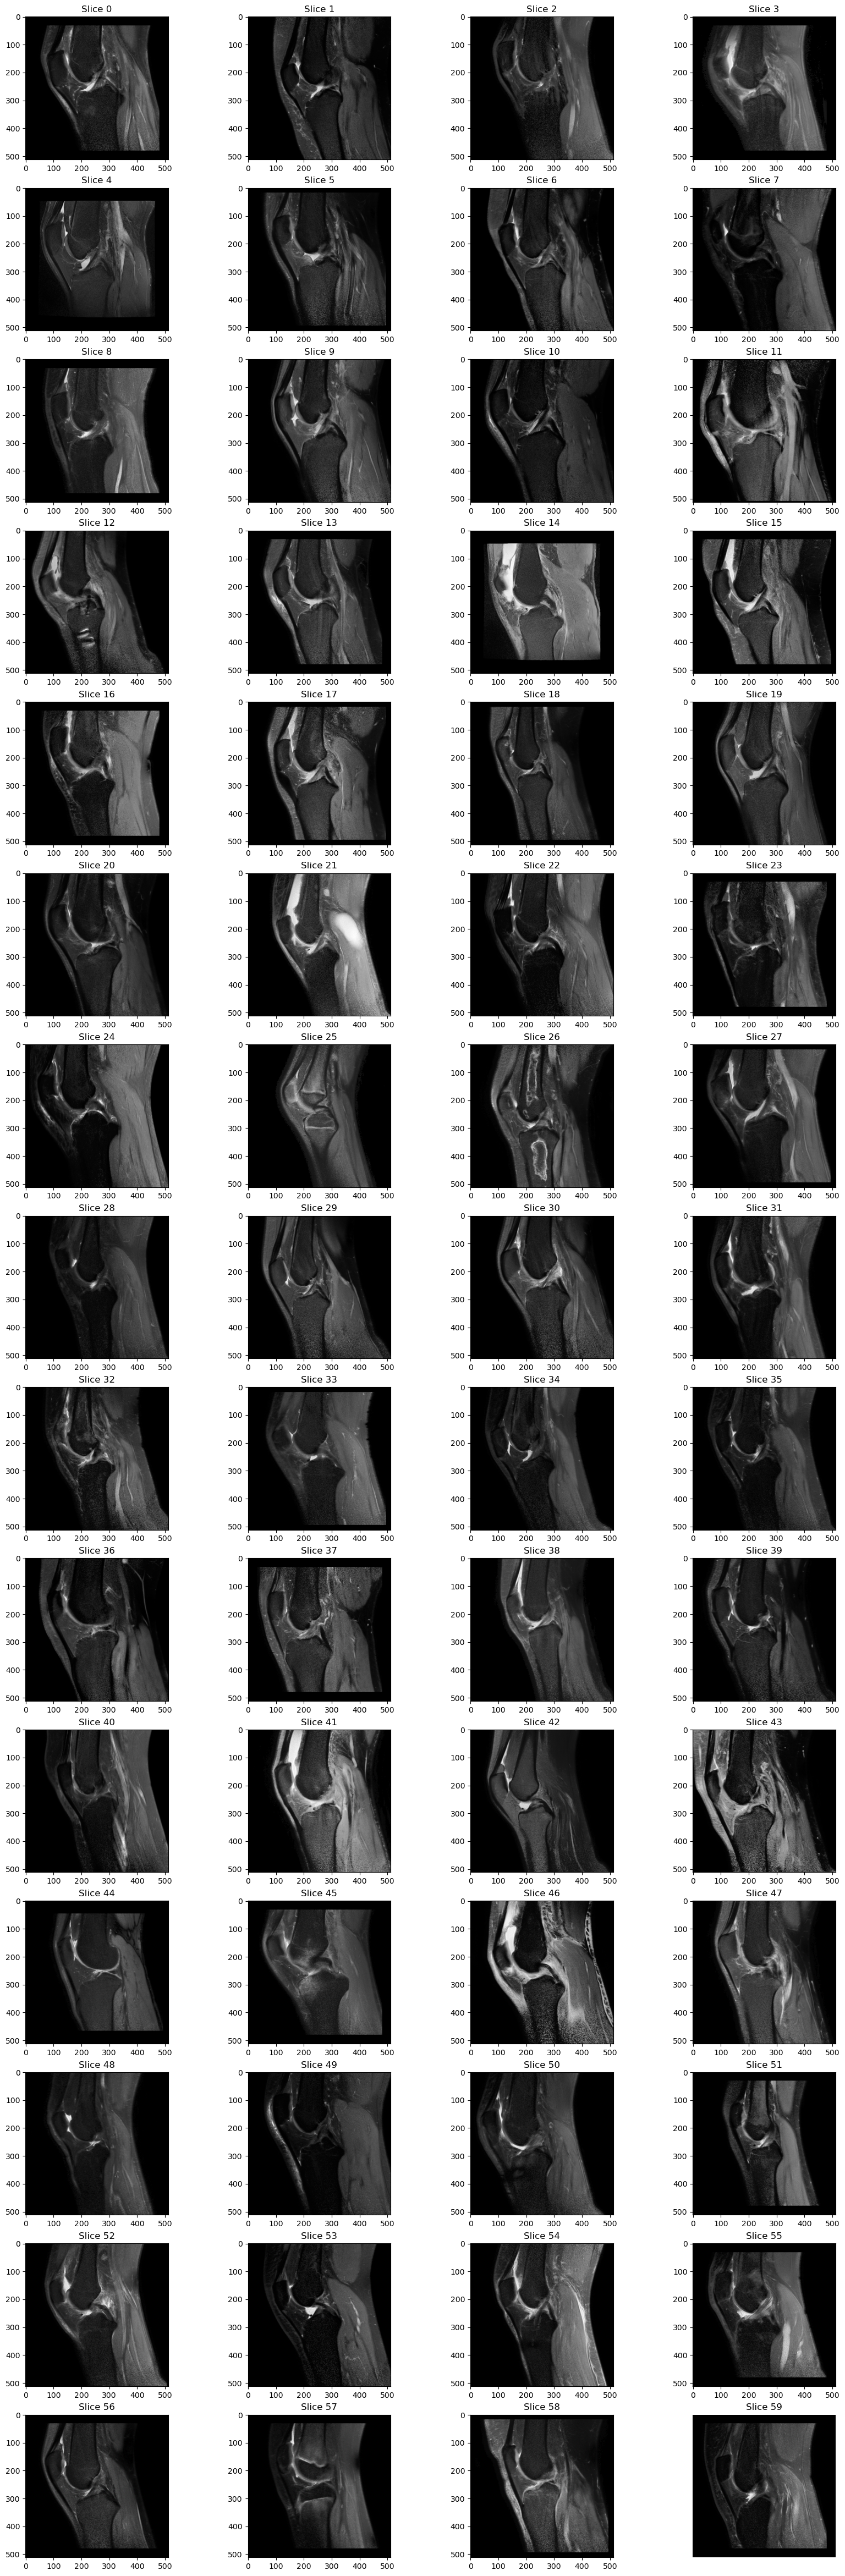

In [44]:
view = "sagittal"
disease_num = 1

names,labels_df,pathology = case_names(disease_num)
predictions = predict(names,disease_num,view)
plot(names,labels_df,pathology,view,disease_num,predictions)

In [6]:
label = pd.read_csv("try.csv")
names = label["StudyUID"].tolist()
try_2 = []
for name in names:
    dictionary = {}
    predict_slice = label.loc[label["StudyUID"]==name]["predict_slice"].tolist()
    sagittal_location = label.loc[label["StudyUID"]==name]["sagittal_location"].tolist()[0]

    if isinstance(sagittal_location,str):
        sagittal_location = ast.literal_eval(sagittal_location)
        if predict_slice[0] != sagittal_location[2]:
            predict_slice[0] = sagittal_location[2]
    
    dictionary["StudyUID"] = name
    dictionary["predict_slice"] = predict_slice[0]
    dictionary["sagittal_location"] = sagittal_location

    try_2.append(dictionary)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(try_2)

# If index is not specified in the DataFrame, set it to None
if df.index.name is None:
    df.index.name = ''

# Write the DataFrame to a CSV file
df.to_csv('try_2.csv', index=False)

In [7]:
import SimpleITK as sitk
import numpy as np
import torch

case_path = "../../Examples_for_output/resize_input.nii"
img = sitk.ReadImage(case_path)
series = sitk.GetArrayFromImage(img).astype(np.float32)[10,:,:].squeeze()
# series = zoom(series, (1,0.4375,0.4375)) # shrimp to 224: (1,0.4375,0.4375)
series = torch.tensor(np.stack((series,)*3, axis=0))
print(series.shape)

torch.Size([3, 512, 512])
